In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import sys, os
sys.path.append('../')

In [4]:
from rankutils.utilities import ndarray_bin_to_int
from rankutils.drawing import colors_from_cmap

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def load_transition_diffs(dfile, nonzero=True):
    
    diffs_ = np.load(dfile)
    diffs = [diffs_['diffs_00'], diffs_['diffs_01'], diffs_['diffs_10'], diffs_['diffs_11']]
    del diffs_
    
    if nonzero:
        for i in range(len(diffs)):
            nzidx = np.flatnonzero(diffs[i])
            diffs[i] = diffs[i][nzidx]
            
    return diffs
    

In [7]:
def plot_topk_labeling_freq(freq, t=0.0, ordered=False, ax=None, bar_kw={}, **kwargs):
    
    cmapname = kwargs.get('cmapname', 'Purples')
    label = kwargs.get('label', None)
    
    if ordered:
        x = np.argsort(freq)[::-1]
        y = freq[x]
    else:
        x = np.arange(freq.size)
        y = freq[x]
        
    valid_idx = np.flatnonzero(y >= t)
    valid_x = x[valid_idx]
    valid_y = y[valid_idx]
    
    c = colors_from_cmap(cmapname, valid_y, (0.5, 1.0))
    
    rects = ax.bar(np.arange(valid_y.size), valid_y, 0.8, 0.0, align='center', color=c, **bar_kw)
    
    for r in rects:
        px, py = r.get_xy()
        bw = r.get_width()
        bh = r.get_height()
        
        ax.text(px + bw/2, py + bh + 0.005, "{0:0.1%}".format(bh), fontsize=12, bbox={'alpha': 0.0},
                 horizontalalignment='center')
    
    ax.set_xticks(np.arange(valid_y.size))
    ax.set_xticklabels([np.binary_repr(v, width=9) for v in valid_x])
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="left",
             rotation_mode="anchor")
    
    ax.set_ylim(0.0, 1.0)
    
    return

In [8]:
def plot_transition_stats(diffs_):
        
    diffs = []

    for key in diffs_:
        nzidx = np.flatnonzero(diffs_[key])
        diffs.append(diffs_[key][nzidx])
        
    diff_mean = [np.mean(d) for d in diffs]
    diff_median = [np.median(d) for d in diffs]
    diff_std = [np.std(d) for d in diffs]
    diff_min = [np.min(d) for d in diffs]
    diff_max = [np.max(d) for d in diffs]

    fig, ax = plt.subplots(1)
    fig.set_size_inches((15, 10))
    ax.set_title('Sequential Score Statistics\nPlaces365 VGG16'.format(t))
    ax.set_ylabel('Sequential Score Difference')
    ax.set_xlabel('Type of Labeling')

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['0 -> 0', '0 -> 1', '1 -> 0', '1 -> 1'])

    x = np.arange(4)
    y = diff_mean
    yerr = [np.array([0, 0, 0, 0]), np.array(diff_std)]
    ax.errorbar(x, y, yerr=yerr, ecolor='black', fmt='o', capsize=5, color='purple', 
                label='Mean ± Std Sequential Diff', markersize=5)

    ax.scatter(x, diff_median, s=70, color='magenta', label='Median Sequential Diff (log)', marker='v', alpha=0.5)
    ax.scatter(x, diff_min, s=50, color='red', label='2nd Min. Sequential Diff', marker='s', alpha=0.5)
    ax.scatter(x, diff_max, s=50, color='blue', label='Max. Sequential Diff', marker='s', alpha=0.5)

    ax.set_ylim(bottom=10**-7, top=10**5)
    ax.set_yscale('log')

    ax.legend()

In [9]:
def boxplot_transition_diff(diffs, title):
    
    import matplotlib.lines as mlines
    
    fig, ax = plt.subplots(1)
    fig.set_size_inches((10, 10))
    ax.set_title(title)
    ax.set_ylabel('Sequential Score Difference (log)')
    ax.set_xlabel('Type of Label Transition')
    
    blim = np.min([np.min(d) for d in diffs])

    mc = colors_from_cmap('Greens', 0.7)[0]
    ax.boxplot(diffs,
               medianprops=dict(linewidth=2, color='red'),
               showmeans=True, meanprops=dict(marker='v', markersize=12, markerfacecolor=mc, markeredgecolor=mc))
    
    ax.set_xticklabels(["0 -> 0", "0 -> 1", "1 -> 0", "1 -> 1"])
    
    ax.set_yscale('log')
    ax.set_ylim(bottom=blim*0.1)
    
    mean_handler = mlines.Line2D([], [], color=mc, marker='v', linewidth=0.05, markersize=12, label='Mean')
    ax.legend(handles=[mean_handler])
    
    return


In [10]:
def plot_transition_freq(t_freq, title, ax=None, bar_kw=dict(), **kwargs):
    
    yscale = kwargs.get('yscale', 'linear')
    cmapname = kwargs.get('cmapname', 'tab20b')
    cmap = plt.get_cmap(cmapname)
    c = cmap(np.arange(t_freq.size))
    
    if not ax:
        ax = plt.gca
        
    ax.set_title(title)
    
    x = np.arange(0, 4)
    y = t_freq.reshape(-1)
    
    ax.bar(x, y, 0.8, 0.0, align='center', color=c, **bar_kw)
    
    # X axis setup
    ax.set_xlabel("Type of Transition")
    ax.set_xticks(x)
    _ = ax.set_xticklabels(["0 -> 0", "0 -> 1", "1 -> 0", "1 -> 1"])
    
    # Y axis setup
    ax.set_ylabel("Frequency")
    ax.set_yscale(yscale)
    
    ax.legend()
    
    return

### Defs

In [11]:
t = 0.005
lfreq_figsize = ((16, 8))

***
# Top-k Labeling Frequencies

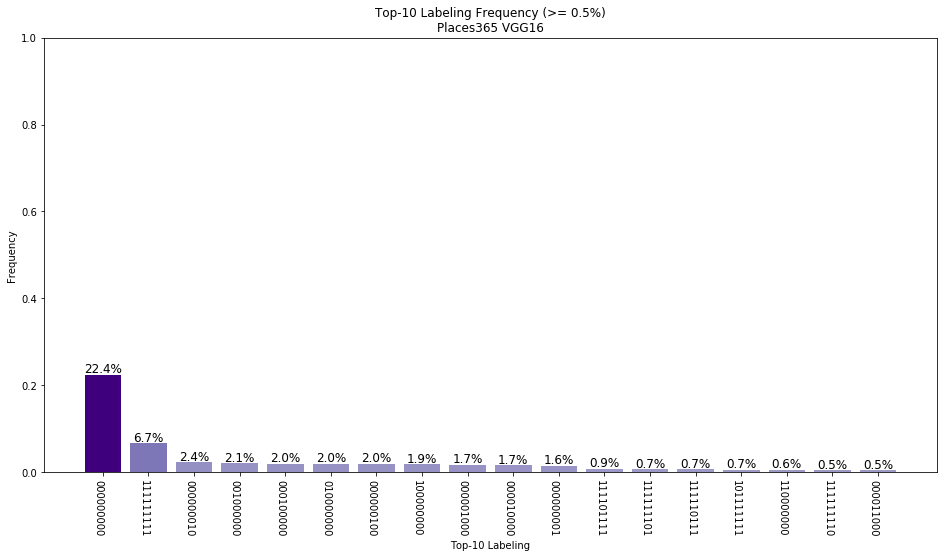

In [12]:
labels = np.load('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/places365/desc1-vgg16-DEEPFV/0000.places365.vgg16.irp_lbls.npy')
labels_int = ndarray_bin_to_int(labels[:, 1:])
freq = np.bincount(labels_int.astype(np.int64), minlength=512)/labels_int.size

fig, ax = plt.subplots(1)
fig.set_size_inches((lfreq_figsize))
ax.set_title('Top-10 Labeling Frequency (>= {0:0.1%})\nPlaces365 VGG16'.format(t))
ax.set_ylabel('Frequency')
ax.set_xlabel('Top-10 Labeling')

plot_topk_labeling_freq(freq, t, ordered=True, ax=ax)

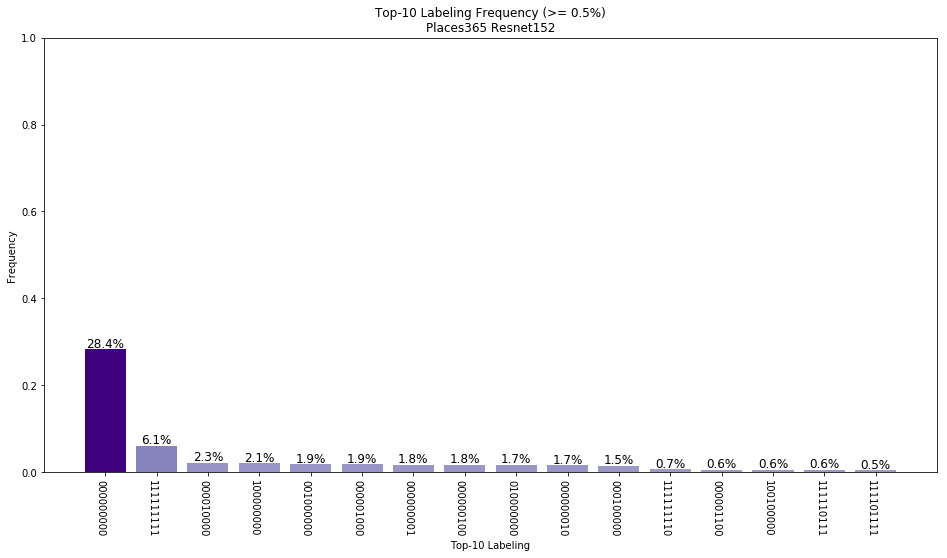

In [13]:
labels = np.load('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/places365/desc2-resnet152-DEEPFV/0000.places365.resnet152.irp_lbls.npy')
labels_int = ndarray_bin_to_int(labels[:, 1:])
freq = np.bincount(labels_int.astype(np.int64), minlength=512)/labels_int.size

fig, ax = plt.subplots(1)
fig.set_size_inches((lfreq_figsize))
ax.set_title('Top-10 Labeling Frequency (>= {0:0.1%})\nPlaces365 Resnet152'.format(t))
ax.set_ylabel('Frequency')
ax.set_xlabel('Top-10 Labeling')

plot_topk_labeling_freq(freq, t, ordered=True, ax=ax)

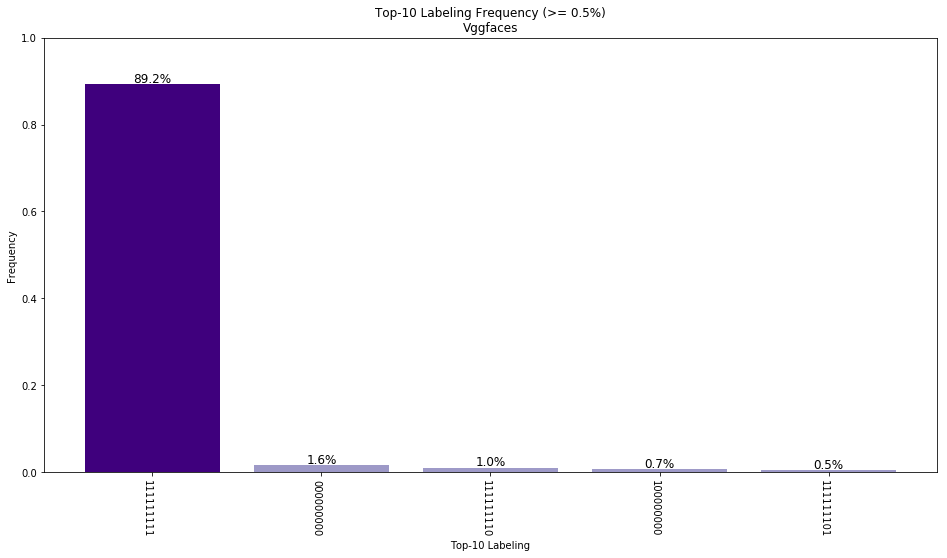

In [14]:
labels = np.load('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/vggfaces/desc1-DEEPFV/0001.vggfaces.deepv.irp_lbls.npy')
labels_int = ndarray_bin_to_int(labels[:, 1:])
freq = np.bincount(labels_int.astype(np.int64), minlength=512)/labels_int.size

fig, ax = plt.subplots(1)
fig.set_size_inches((lfreq_figsize))
ax.set_title('Top-10 Labeling Frequency (>= {0:0.1%})\nVggfaces'.format(t))
ax.set_ylabel('Frequency')
ax.set_xlabel('Top-10 Labeling')

plot_topk_labeling_freq(freq, t, ordered=True, ax=ax)

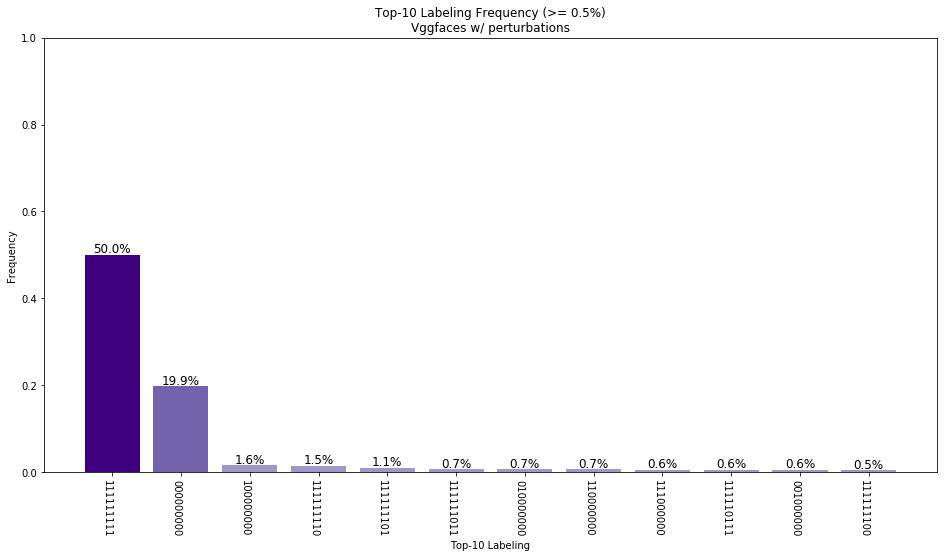

In [15]:
labels = np.load('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/vggfaces/desc2-PERT-DEEPFV/0002.vggfaces.pert-deepv.irp_lbls.npy')
labels_int = ndarray_bin_to_int(labels[:, 1:])
freq = np.bincount(labels_int.astype(np.int64), minlength=512)/labels_int.size

fig, ax = plt.subplots(1)
fig.set_size_inches((lfreq_figsize))
ax.set_title('Top-10 Labeling Frequency (>= {0:0.1%})\nVggfaces w/ perturbations'.format(t))
ax.set_ylabel('Frequency')
ax.set_xlabel('Top-10 Labeling')

plot_topk_labeling_freq(freq, t, ordered=True, ax=ax)

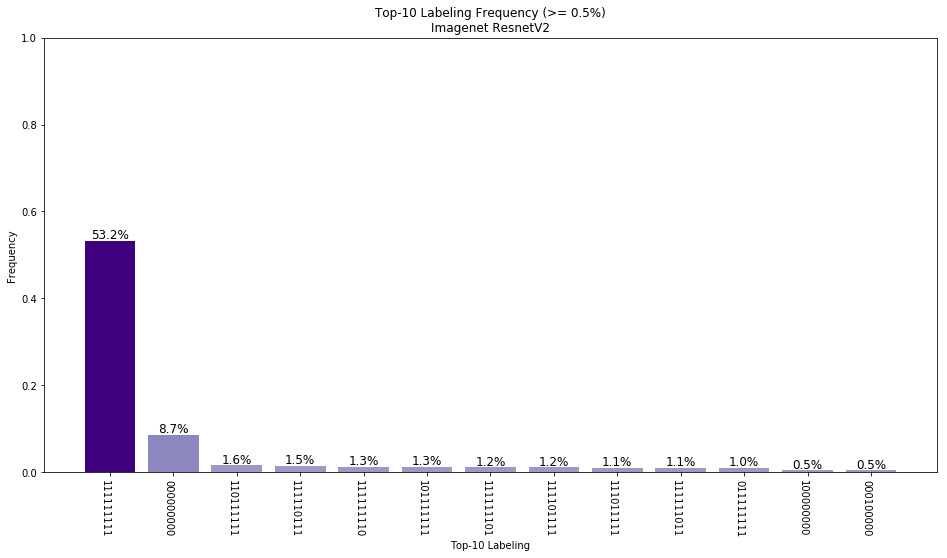

In [16]:
labels = np.load('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/imagenet/desc1-resnetV2-DEEPFV/0000.imagenet.resnetv2.irp_lbls.npy')
labels_int = ndarray_bin_to_int(labels[:, 1:])
freq = np.bincount(labels_int.astype(np.int64), minlength=512)/labels_int.size

fig, ax = plt.subplots(1)
fig.set_size_inches((lfreq_figsize))
ax.set_title('Top-10 Labeling Frequency (>= {0:0.1%})\nImagenet ResnetV2'.format(t))
ax.set_ylabel('Frequency')
ax.set_xlabel('Top-10 Labeling')

plot_topk_labeling_freq(freq, t, ordered=True, ax=ax)

***
# Sequential Score Difference Stats

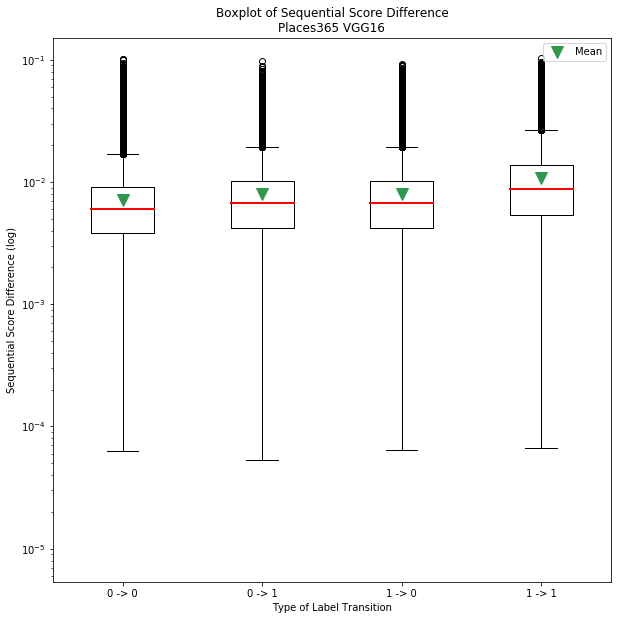

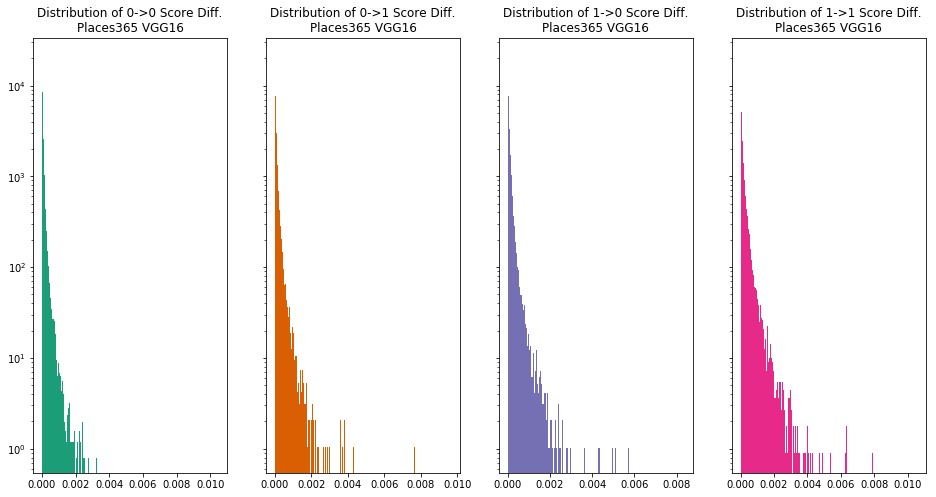

In [17]:
diffs = load_transition_diffs('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./places365_e1-vgg16.t_diffs.10:1000.npz')

boxplot_transition_diff([np.sqrt(d) for d in diffs], 'Boxplot of Sequential Score Difference\nPlaces365 VGG16')

fig, a = plt.subplots(1, 4, sharey=True)
ax0, ax1, ax2, ax3 = a
fig.set_size_inches((lfreq_figsize))
c = plt.get_cmap('Dark2')

ax0.set_title('Distribution of 0->0 Score Diff.\nPlaces365 VGG16')
y, x = np.histogram(diffs[0], bins='auto', density=True)
ax0.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(0))
ax0.set_yscale('log')

ax1.set_title('Distribution of 0->1 Score Diff.\nPlaces365 VGG16')
y, x = np.histogram(diffs[1], bins='auto', density=True)
ax1.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(1))
ax1.set_yscale('log')

ax2.set_title('Distribution of 1->0 Score Diff.\nPlaces365 VGG16')
y, x = np.histogram(diffs[2], bins='auto', density=True)
ax2.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(2))
ax2.set_yscale('log')

ax3.set_title('Distribution of 1->1 Score Diff.\nPlaces365 VGG16')
y, x = np.histogram(diffs[3], bins='auto', density=True)
ax3.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(3))
ax3.set_yscale('log')

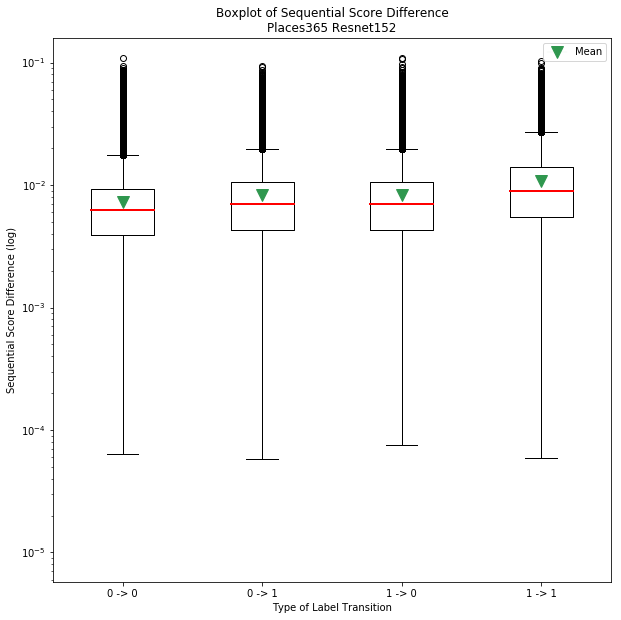

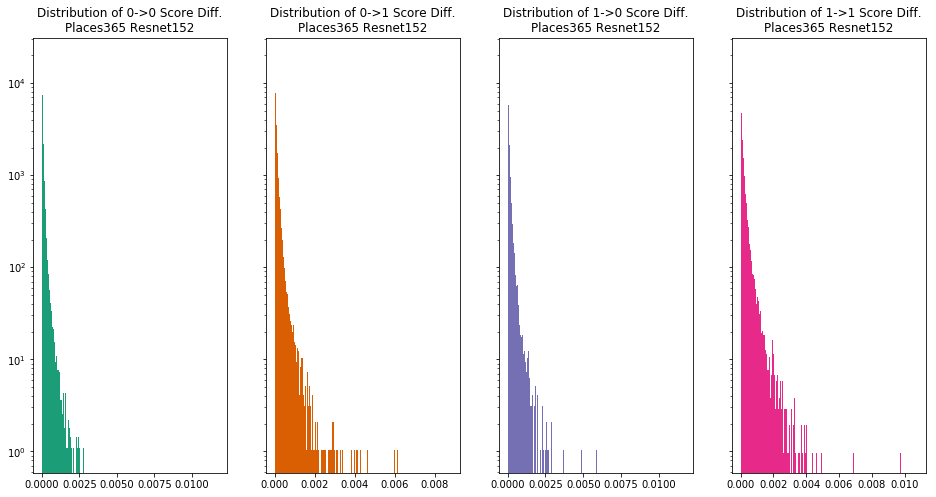

In [18]:
diffs = load_transition_diffs('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./places365_e2-resnet152.t_diffs.10:1000.npz')

boxplot_transition_diff([np.sqrt(d) for d in diffs], 'Boxplot of Sequential Score Difference\nPlaces365 Resnet152')

fig, a = plt.subplots(1, 4, sharey=True)
ax0, ax1, ax2, ax3 = a
fig.set_size_inches((lfreq_figsize))
c = plt.get_cmap('Dark2')

ax0.set_title('Distribution of 0->0 Score Diff.\nPlaces365 Resnet152')
y, x = np.histogram(diffs[0], bins='auto', density=True)
ax0.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(0))
ax0.set_yscale('log')

ax1.set_title('Distribution of 0->1 Score Diff.\nPlaces365 Resnet152')
y, x = np.histogram(diffs[1], bins='auto', density=True)
ax1.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(1))
ax1.set_yscale('log')

ax2.set_title('Distribution of 1->0 Score Diff.\nPlaces365 Resnet152')
y, x = np.histogram(diffs[2], bins='auto', density=True)
ax2.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(2))
ax2.set_yscale('log')

ax3.set_title('Distribution of 1->1 Score Diff.\nPlaces365 Resnet152')
y, x = np.histogram(diffs[3], bins='auto', density=True)
ax3.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(3))
ax3.set_yscale('log')

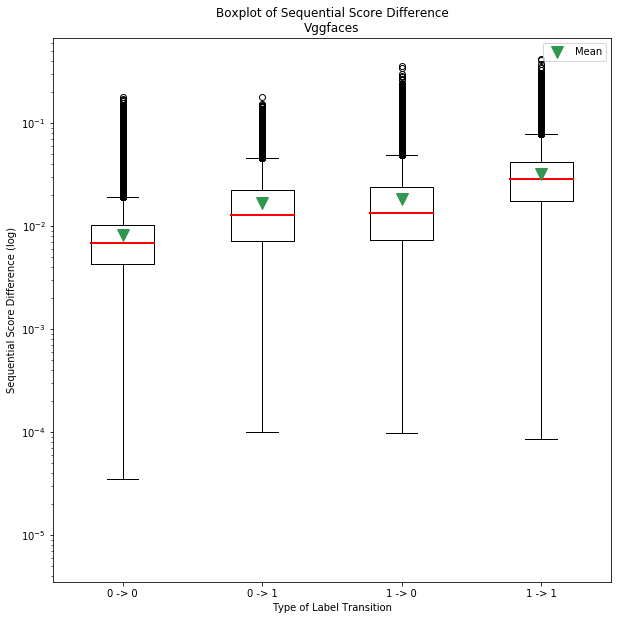

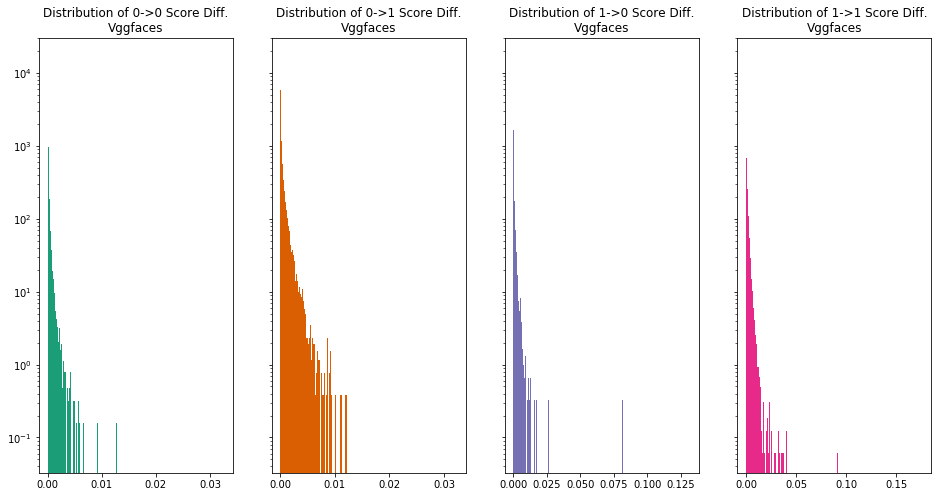

In [19]:
diffs = load_transition_diffs('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./vggfaces_e1-vgg.t_diffs.10:1000.npz')

boxplot_transition_diff([np.sqrt(d) for d in diffs], 'Boxplot of Sequential Score Difference\nVggfaces')

fig, a = plt.subplots(1, 4, sharey=True)
ax0, ax1, ax2, ax3 = a
fig.set_size_inches((lfreq_figsize))
c = plt.get_cmap('Dark2')

ax0.set_title('Distribution of 0->0 Score Diff.\nVggfaces')
y, x = np.histogram(diffs[0], bins='auto', density=True)
ax0.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(0))
ax0.set_yscale('log')

ax1.set_title('Distribution of 0->1 Score Diff.\nVggfaces')
y, x = np.histogram(diffs[1], bins='auto', density=True)
ax1.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(1))
ax1.set_yscale('log')

ax2.set_title('Distribution of 1->0 Score Diff.\nVggfaces')
y, x = np.histogram(diffs[2], bins='auto', density=True)
ax2.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(2))
ax2.set_yscale('log')

ax3.set_title('Distribution of 1->1 Score Diff.\nVggfaces')
y, x = np.histogram(diffs[3], bins='auto', density=True)
ax3.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(3))
ax3.set_yscale('log')

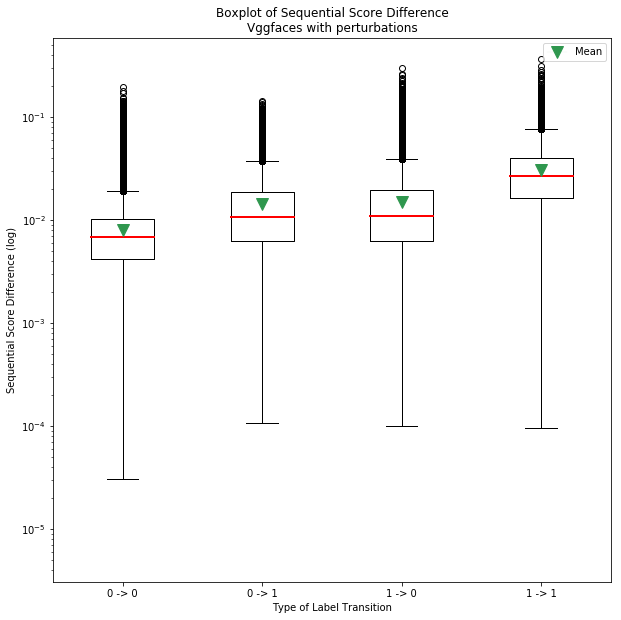

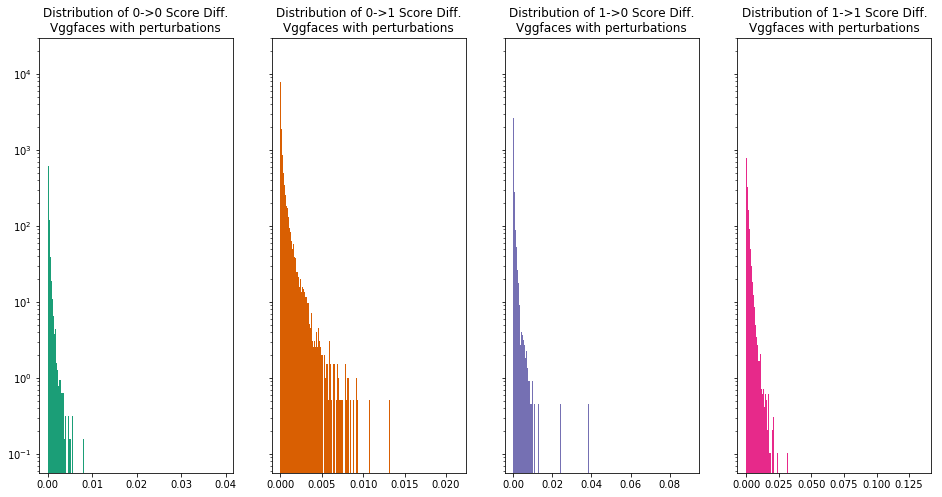

In [20]:
diffs = load_transition_diffs('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./vggfaces_e2-vgg-w-pert.t_diffs.10:1000.npz')

boxplot_transition_diff([np.sqrt(d) for d in diffs], 'Boxplot of Sequential Score Difference\nVggfaces with perturbations')

fig, a = plt.subplots(1, 4, sharey=True)
ax0, ax1, ax2, ax3 = a
fig.set_size_inches((lfreq_figsize))
c = plt.get_cmap('Dark2')

ax0.set_title('Distribution of 0->0 Score Diff.\nVggfaces with perturbations')
y, x = np.histogram(diffs[0], bins='auto', density=True)
ax0.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(0))
ax0.set_yscale('log')

ax1.set_title('Distribution of 0->1 Score Diff.\nVggfaces with perturbations')
y, x = np.histogram(diffs[1], bins='auto', density=True)
ax1.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(1))
ax1.set_yscale('log')

ax2.set_title('Distribution of 1->0 Score Diff.\nVggfaces with perturbations')
y, x = np.histogram(diffs[2], bins='auto', density=True)
ax2.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(2))
ax2.set_yscale('log')

ax3.set_title('Distribution of 1->1 Score Diff.\nVggfaces with perturbations')
y, x = np.histogram(diffs[3], bins='auto', density=True)
ax3.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(3))
ax3.set_yscale('log')

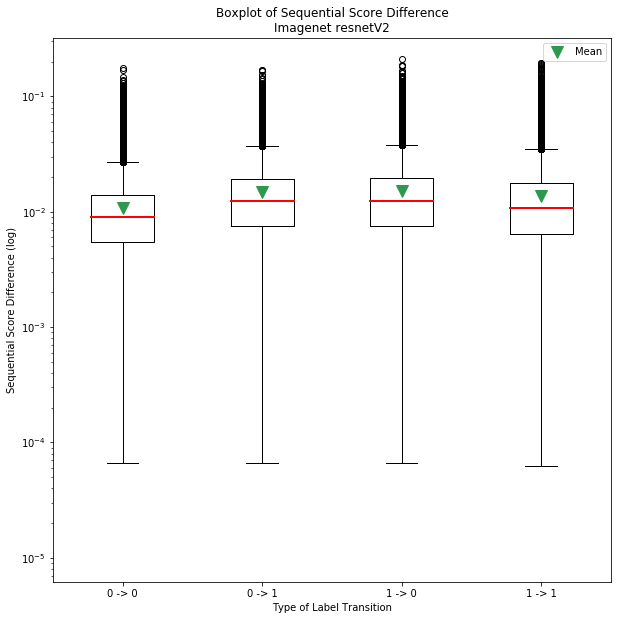

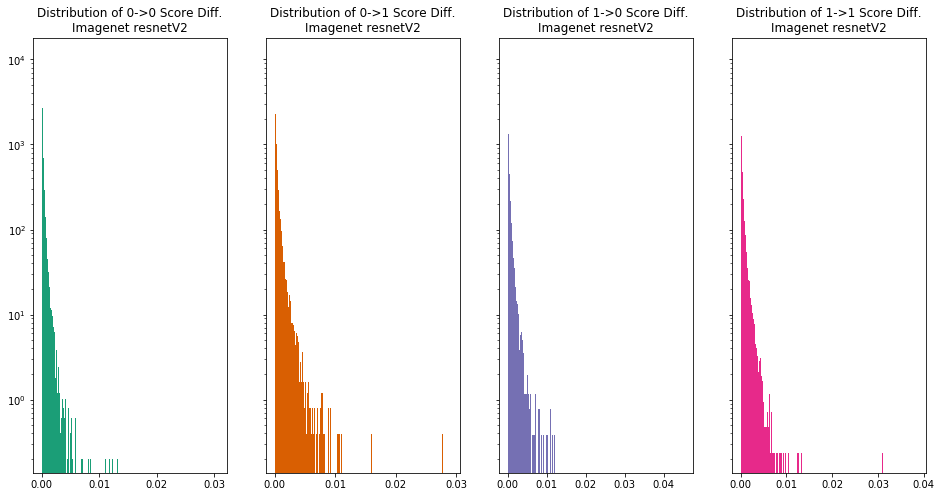

In [21]:
diffs = load_transition_diffs('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/misc./imagenet_e1-resnetv2.t_diffs.10:1000.npz')

boxplot_transition_diff([np.sqrt(d) for d in diffs], 'Boxplot of Sequential Score Difference\nImagenet resnetV2')

fig, a = plt.subplots(1, 4, sharey=True)
ax0, ax1, ax2, ax3 = a
fig.set_size_inches((lfreq_figsize))
c = plt.get_cmap('Dark2')

ax0.set_title('Distribution of 0->0 Score Diff.\nImagenet resnetV2')
y, x = np.histogram(diffs[0], bins='auto', density=True)
ax0.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(0))
ax0.set_yscale('log')

ax1.set_title('Distribution of 0->1 Score Diff.\nImagenet resnetV2')
y, x = np.histogram(diffs[1], bins='auto', density=True)
ax1.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(1))
ax1.set_yscale('log')

ax2.set_title('Distribution of 1->0 Score Diff.\nImagenet resnetV2')
y, x = np.histogram(diffs[2], bins='auto', density=True)
ax2.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(2))
ax2.set_yscale('log')

ax3.set_title('Distribution of 1->1 Score Diff.\nImagenet resnetV2')
y, x = np.histogram(diffs[3], bins='auto', density=True)
ax3.bar(x[:-1], y, x[1]-x[0], 0.0, align='edge', color=c(3))
ax3.set_yscale('log')